<a href="https://colab.research.google.com/github/Greatandy/2016_2_21/blob/master/estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 使用estimator创建一个DNN模型
import tensorflow as tf
import pandas as pd

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
#train.head()
train_y = train.pop('Species')
test_y = test.pop('Species')

# 标签列现已从数据中删除
#print(train[:5])
#print(train_y[:5])
#print(dict(train[:5]))
def input_fn(features, labels, training=True, batch_size=256):
    """An input function for training or evaluating"""
    # 将输入转换为数据集。
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # 如果在训练模式下混淆并重复数据。
    if training:
        dataset = dataset.shuffle(1000).repeat()

    return dataset.batch(batch_size)

# 特征列描述了如何使用输入。
my_feature_columns = []
for key in train.keys():
    print("key is ", key)
    my_feature_columns.append(tf.feature_column.numeric_column(key=key)) #我们将构建一个特征列的列表，以告知 Estimator 模型将 4 个特征都表示为 32 位浮点值。(默认的)

print(my_feature_columns)
# 构建一个拥有两个隐层，隐藏节点分别为 30 和 10 的深度神经网络。
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns, #相当于输入是4个浮点值
    # 隐层所含结点数量分别为 30 和 10.
    hidden_units=[30, 10],
    # 模型必须从三个类别中做出选择。
    n_classes=3)
# 训练模型。
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

# 由模型生成预测
expected = ['Setosa', 'Versicolor', 'Virginica']
predict_x = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}
def input_fn_predict(features, batch_size=256):
    """An input function for prediction."""
    # 将输入转换为无标签数据集。
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

predictions = classifier.predict(
    input_fn=lambda: input_fn_predict(predict_x))
for pred_dict, expec in zip(predictions, expected):
    print("pred_dict is ", pred_dict)
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%), expected "{}"'.format(
        SPECIES[class_id], 100 * probability, expec))



In [ ]:
## 使用LR模型预测Titanic号乘客生存，里面涉及到类别特征，连续特征等的处理，以及特征的组合
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')
dftrain.head()
#dftrain.shape[0], dfeval.shape[0]
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone'] # 类别特征
NUMERIC_COLUMNS = ['age', 'fare'] #数值特征

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) #将特征列映射为one-hot形式

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) #把numpy数据转化为tensor，注意这里直接把features和label合在一起了。
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1): #单独取一个batch内的features和label
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

  age_column = feature_columns[7]
  print(tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy())
  gender_column = feature_columns[0]
  print(tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy())

'''
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result) 
'''
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100) # 增加特征组合（相当于多了一些0-1编码）, acc由：74.2%->76.89%
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns) 
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result) 
pred_dicts = list(linear_est.predict(eval_input_fn))
print(pred_dicts[0])
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts]) #取存活的概率

#probs.plot(kind='hist', bins=20, title='predicted probabilities')
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

print("y_eval is ", y_eval[:10])
print("probs is ", probs[:10])

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

accuracy                  0.833333
accuracy_baseline         0.625000
auc                       0.874197
auc_precision_recall      0.858434
average_loss              0.406781
label/mean                0.375000
loss                      0.406781
precision                 0.795699
prediction/mean           0.383399
recall                    0.747475
global_step             100.000000
dtype: float64
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0vkh9uc1/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Exception ignored in: <function CapturableResource.__del__ at 0x7f0352d9be60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 269, in __del__
    with self._destruction_context():
AttributeError: 'TreeEnsemble' object has no attribute '_destruction_context'


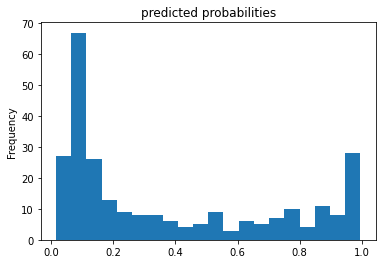

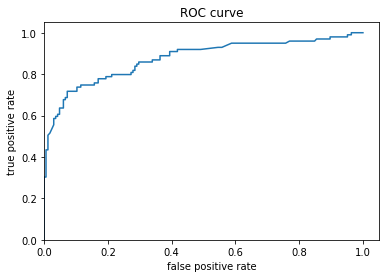

In [31]:
#使用提升树来进行分类 acc: 83.3%
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

# 加载数据集。
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

import tensorflow as tf
tf.random.set_seed(123)
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0])) #取 pandas的第0列（其实就是第1列）
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())


# 使用大小为全部数据的 batch ，因为数据规模非常小.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # 对于训练，可以按需多次循环数据集（n_epochs=None）。
    dataset = dataset.repeat(n_epochs)
    # 在内存中训练不使用 batch。
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# 训练与评估的输入函数。
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
# 由于数据存入内存中，在每层使用全部数据会更快。
# 上面一个 batch 定义为整个数据集。
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches) #每一层使用的数据，所有数据

# 一旦建立了指定数量的树，模型将停止训练，
# 而不是基于训练步数。
est.train(train_input_fn, max_steps=100)

# 评估。
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result)) 
'''
accuracy                  0.833333
accuracy_baseline         0.625000
auc                       0.874197
auc_precision_recall      0.858434
average_loss              0.406781
label/mean                0.375000
loss                      0.406781
precision                 0.795699
prediction/mean           0.383399
recall                    0.747475
global_step             100.000000
dtype: float64
'''
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()


from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

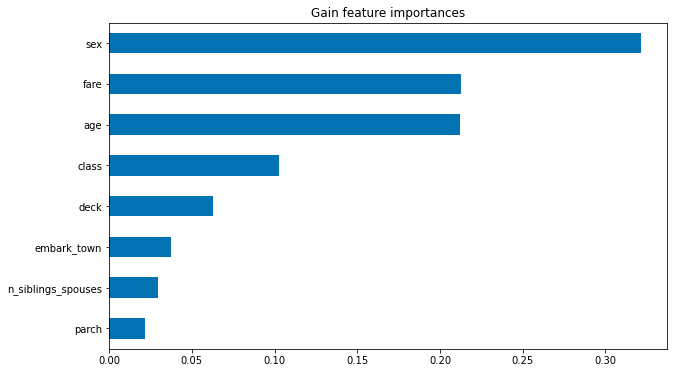

In [40]:
import numpy as np
import pandas as pd
from IPython.display import clear_output

# 加载数据集。
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')
import tensorflow as tf
tf.random.set_seed(123)
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # 需要使用独热编码（one-hot-encoding）处理非数值特征。
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

# 当数据集小的时候，将整个数据集作为一个 batch。
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # 训练时让数据迭代尽可能多次 （n_epochs=None）。
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# 训练并评估输入函数。
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

params = {
  'n_trees': 100,
  'max_depth': 5,
  'n_batches_per_layer': 1,
  # 为了得到 DFCs，请设置 center_bias = True。这将强制
  # 模型在使用特征（例如：回归中训练集标签的均值，分类中使
  # 用交叉熵损失函数时的对数几率）前做一个初始预测。
  'center_bias': True
}

#est = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batches) #83.3%
est = tf.estimator.BoostedTreesClassifier(feature_columns, **params) # 80.68%
# 训练模型。
est.train(train_input_fn, max_steps=100)

# 评估。
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()
'''
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# 在内存中的输入方程请不要对数据分批。
def make_inmemory_train_input_fn(X, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

# 训练模型。
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
print(est.evaluate(eval_input_fn)) #80.3%
'''
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# 可视化重要性。
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

In [1]:
import tensorflow as tf

import numpy as np
import tensorflow_datasets as tfds

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam')
model.summary()
def input_fn():
  split = tfds.Split.TRAIN
  dataset = tfds.load('iris', split=split, as_supervised=True)
  dataset = dataset.map(lambda features, labels: ({'dense_input':features}, labels)) #这块没有调试通，先不管了
  dataset = dataset.batch(32).repeat()
  
  return dataset
for features_batch, labels_batch in input_fn().take(1): #取1个batch的样本
  print(features_batch)
  print(labels_batch)
import tempfile
model_dir = tempfile.mkdtemp()
keras_estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model, model_dir=model_dir)

keras_estimator.train(input_fn=input_fn, steps=500)
eval_result = keras_estimator.evaluate(input_fn=input_fn, steps=10)
print('Eval result: {}'.format(eval_result))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Shuffling and writing examples to /root/tensorflow_datasets/iris/2.0.0.incompleteXCAXX0/iris-train.tfrecord


Dataset iris downloaded and prepared to /root/tensorflow_datasets/iris/2.0.0. Subsequent calls will reuse this data.
{'dense_input': <tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[5.1, 3.4, 1.5, 0.2],
       [7.7, 3. , 6.1, 2.3],
       [5.7, 2.8, 4.5, 1.3],
       [6.8, 3.2, 5.9, 2.3],
       [5.2, 3.4, 1.4, 0.2],
       [5.6, 2.9, 3.6, 1.3],
       [5.5, 2.6, 4.4, 1.2],
       [5.5, 2.4, 3.7, 1. ],
       [4.6, 3.4, 1.4, 0.3],
       [7.7, 2.8, 6.7, 2. ],
       [7. , 3.2, 4.7, 1.4],
       [4.6, 3.2, 1.4, 0.2],
       [6.5, 3. , 5.2, 2. ],
       [5.5, 4.2, 1.4, 0.2],
       [5.4, 3.9, 1.3, 0.4],
       [5. , 3.5, 1.3, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [4.8, 3. , 1.4, 0.1],
       [6.5, 3. , 5.8, 2.2],
       [7.6, 3. , 6.6, 2.1],
       [6.7, 3.3, 5.7, 2.1],
       [7.9, 3.8, 6.4, 2. ],
       [6.7, 3. , 5.2, 2.3],
       [5.8, 4. , 1.2, 0.2],
       [6.3, 2.5, 5. , 1.9],
       [5. , 3. , 1.6, 0.2],
       [6.9, 3.1, 5.1, 2.3],
       [6.1, 3. , 4.6, 1.4],
      

INFO:tensorflow:Using default config.


INFO:tensorflow:Using the Keras model provided.


INFO:tensorflow:Using the Keras model provided.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpg8ep38u3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpg8ep38u3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='/tmp/tmpg8ep38u3/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='/tmp/tmpg8ep38u3/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting from: /tmp/tmpg8ep38u3/keras/keras_model.ckpt


INFO:tensorflow:Warm-starting from: /tmp/tmpg8ep38u3/keras/keras_model.ckpt


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-started 4 variables.


INFO:tensorflow:Warm-started 4 variables.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpg8ep38u3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpg8ep38u3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.5642478, step = 0


INFO:tensorflow:loss = 2.5642478, step = 0


INFO:tensorflow:global_step/sec: 390.348


INFO:tensorflow:global_step/sec: 390.348


INFO:tensorflow:loss = 1.2532394, step = 100 (0.260 sec)


INFO:tensorflow:loss = 1.2532394, step = 100 (0.260 sec)


INFO:tensorflow:global_step/sec: 399.269


INFO:tensorflow:global_step/sec: 399.269


INFO:tensorflow:loss = 0.75821537, step = 200 (0.252 sec)


INFO:tensorflow:loss = 0.75821537, step = 200 (0.252 sec)


INFO:tensorflow:global_step/sec: 382.734


INFO:tensorflow:global_step/sec: 382.734


INFO:tensorflow:loss = 0.63012266, step = 300 (0.266 sec)


INFO:tensorflow:loss = 0.63012266, step = 300 (0.266 sec)


INFO:tensorflow:global_step/sec: 414.417


INFO:tensorflow:global_step/sec: 414.417


INFO:tensorflow:loss = 0.5574951, step = 400 (0.241 sec)


INFO:tensorflow:loss = 0.5574951, step = 400 (0.241 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500...


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmpg8ep38u3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmpg8ep38u3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500...


INFO:tensorflow:Loss for final step: 0.5488101.


INFO:tensorflow:Loss for final step: 0.5488101.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-06-29T10:41:53


INFO:tensorflow:Starting evaluation at 2021-06-29T10:41:53


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpg8ep38u3/model.ckpt-500


INFO:tensorflow:Restoring parameters from /tmp/tmpg8ep38u3/model.ckpt-500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


INFO:tensorflow:Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


INFO:tensorflow:Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


INFO:tensorflow:Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


INFO:tensorflow:Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


INFO:tensorflow:Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


INFO:tensorflow:Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


INFO:tensorflow:Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


INFO:tensorflow:Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


INFO:tensorflow:Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


INFO:tensorflow:Evaluation [10/10]


INFO:tensorflow:Inference Time : 0.24750s


INFO:tensorflow:Inference Time : 0.24750s


INFO:tensorflow:Finished evaluation at 2021-06-29-10:41:54


INFO:tensorflow:Finished evaluation at 2021-06-29-10:41:54


INFO:tensorflow:Saving dict for global step 500: global_step = 500, loss = 0.42952743


INFO:tensorflow:Saving dict for global step 500: global_step = 500, loss = 0.42952743


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /tmp/tmpg8ep38u3/model.ckpt-500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /tmp/tmpg8ep38u3/model.ckpt-500


Eval result: {'loss': 0.42952743, 'global_step': 500}


# 新段落

# 新段落